Learning from: https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/

using USD_INR exchange rate data

In [1]:
import pandas as pd
import numpy as np
import keras
import matplotlib.pyplot as plt
%matplotlib inline

import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


# Basic LSTM

In [2]:
dat = pd.read_csv('USD_INR.csv')

In [3]:
price_dat = dat['Price']

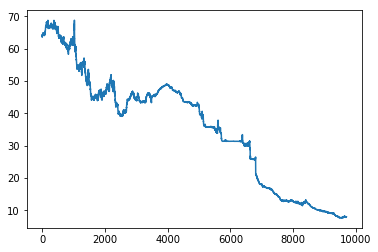

In [4]:
plt.plot(price_dat)

In [5]:
print(np.mean(price_dat.values))
print(np.std(price_dat.values))

35.5577077447
17.540190695


### Normalize

In [6]:
price_dat = price_dat.values.ravel().reshape(-1,1)

In [7]:
scaler = MinMaxScaler(feature_range=(0, 1))
price_dat = scaler.fit_transform(price_dat)

In [8]:
print(np.mean(price_dat))
print(np.std(price_dat))

0.456077018318
0.286956084989


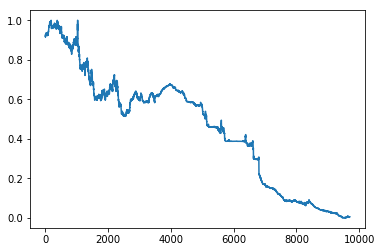

In [9]:
plt.plot(price_dat)

### Train Test Split

In [10]:
ratio = int(round(len(price_dat)*0.8))
print(ratio)

7758


In [11]:
train_dat = price_dat[:ratio]
valid_dat = price_dat[ratio:]

### Creating look back dataset:

In [12]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0] # if look_back=1, look back 1 datapoint,  if look_back=2, look back 2 datapoints
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0]) # the next point from the look back points
    return np.array(dataX), np.array(dataY)

In [13]:
# reshape into X=t and Y=t+1
look_back = 1 # using past 1 value to predict the next

trainX, trainY = create_dataset(train_dat, look_back)
testX, testY = create_dataset(valid_dat, look_back)

In [14]:
print(trainX.shape)
print(trainY.shape)

(7756, 1)
(7756,)


In [15]:
trainX[:5,:]

array([[ 0.92408998],
       [ 0.9191002 ],
       [ 0.91635174],
       [ 0.91877301],
       [ 0.91607362]])

In [16]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [17]:
print(trainX.shape)


(7756, 1, 1)


In [18]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back))) # 4 in here means 4 LSTM blocks or neurons
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
 - 35s - loss: 0.0090
Epoch 2/100
 - 35s - loss: 2.2377e-05
Epoch 3/100
 - 35s - loss: 2.2617e-05
Epoch 4/100
 - 35s - loss: 2.1635e-05
Epoch 5/100
 - 36s - loss: 2.1810e-05
Epoch 6/100
 - 36s - loss: 2.1904e-05
Epoch 7/100
 - 35s - loss: 2.1110e-05
Epoch 8/100
 - 36s - loss: 2.0766e-05
Epoch 9/100
 - 36s - loss: 2.1023e-05
Epoch 10/100
 - 36s - loss: 2.0615e-05
Epoch 11/100
 - 36s - loss: 2.0614e-05
Epoch 12/100
 - 37s - loss: 2.0501e-05
Epoch 13/100
 - 36s - loss: 2.0126e-05
Epoch 14/100
 - 36s - loss: 1.9376e-05
Epoch 15/100
 - 36s - loss: 1.9805e-05
Epoch 16/100
 - 36s - loss: 2.0230e-05
Epoch 17/100
 - 35s - loss: 1.9323e-05
Epoch 18/100
 - 36s - loss: 1.9156e-05
Epoch 19/100
 - 36s - loss: 1.8696e-05
Epoch 20/100
 - 36s - loss: 1.8746e-05
Epoch 21/100
 - 36s - loss: 1.8549e-05
Epoch 22/100
 - 36s - loss: 1.8400e-05
Epoch 23/100
 - 36s - loss: 1.7666e-05
Epoch 24/100
 - 36s - loss: 1.7457e-05
Epoch 25/100
 - 36s - loss: 1.7579e-05
Epoch 26/100
 - 36s - loss: 1.7555e-05

### Predict in-sample and out-sample

In [19]:
res_insp = model.predict(trainX)
res_outsp = model.predict(testX)

In [20]:
# inverse the transformation back to get the true value:
res_insp = scaler.inverse_transform(res_insp)
trainY = scaler.inverse_transform([trainY])

res_outsp = scaler.inverse_transform(res_outsp)
testY = scaler.inverse_transform([testY])

In [21]:
# RMSE:

trainScore = math.sqrt(mean_squared_error(trainY[0], res_insp[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], res_outsp[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.22 RMSE
Test Score: 0.18 RMSE


In [22]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(price_dat)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(res_insp)+look_back, :] = res_insp
# shift test predictions for plotting
testPredictPlot = np.empty_like(price_dat)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(res_insp)+(look_back*2)+1:len(price_dat)-1, :] = res_outsp
# plot baseline and predictions

#### Original Data:

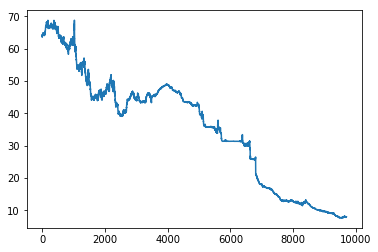

In [23]:

plt.plot(scaler.inverse_transform(price_dat))


#### In-sample Prediction:

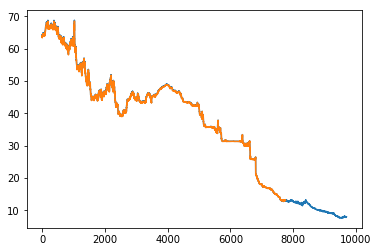

In [24]:
plt.plot(scaler.inverse_transform(price_dat))
plt.plot(trainPredictPlot)


#### Out-sample Prediction:

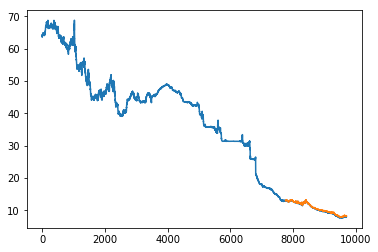

In [25]:
plt.plot(scaler.inverse_transform(price_dat))
plt.plot(testPredictPlot)

# LSTM using Window Method

In [26]:
# reshape into X=t and Y=t+1
look_back = 3 # using past 3 values to predict the next

trainX, trainY = create_dataset(train_dat, look_back)
testX, testY = create_dataset(valid_dat, look_back)

In [27]:
print(trainX.shape)
print(trainY.shape)

(7754, 3)
(7754,)


In [ ]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [ ]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back))) # 4 in here means 4 LSTM blocks or neurons
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
 - 40s - loss: 0.0022
Epoch 2/100
 - 38s - loss: 3.9795e-05
Epoch 3/100
 - 39s - loss: 3.6600e-05
Epoch 4/100
 - 37s - loss: 3.4438e-05
Epoch 5/100
 - 35s - loss: 3.2608e-05
Epoch 6/100
 - 41s - loss: 3.0971e-05
Epoch 7/100
 - 40s - loss: 2.9821e-05
Epoch 8/100
 - 36s - loss: 3.0972e-05
Epoch 9/100
 - 35s - loss: 2.8879e-05
Epoch 10/100
 - 35s - loss: 2.8230e-05
Epoch 11/100
 - 35s - loss: 2.7879e-05
Epoch 12/100
 - 35s - loss: 2.6454e-05
Epoch 13/100
 - 35s - loss: 2.7068e-05
Epoch 14/100
 - 35s - loss: 2.5651e-05
Epoch 15/100
 - 36s - loss: 2.5170e-05
Epoch 16/100
 - 35s - loss: 2.4591e-05
Epoch 17/100
 - 37s - loss: 2.5322e-05
Epoch 18/100
 - 37s - loss: 2.4499e-05
Epoch 19/100
 - 37s - loss: 2.4276e-05
Epoch 20/100
 - 37s - loss: 2.3820e-05
Epoch 21/100
 - 37s - loss: 2.4345e-05
Epoch 22/100
 - 37s - loss: 2.2636e-05
Epoch 23/100
 - 37s - loss: 2.2174e-05
Epoch 24/100
 - 37s - loss: 2.2564e-05
Epoch 25/100
 - 37s - loss: 2.2201e-05
Epoch 26/100
 - 37s - loss: 2.2338e-05

#### Prediction:

In [ ]:
res_insp = model.predict(trainX)
res_outsp = model.predict(testX)

In [ ]:
# inverse the transformation back to get the true value:
res_insp = scaler.inverse_transform(res_insp)
trainY = scaler.inverse_transform([trainY])

res_outsp = scaler.inverse_transform(res_outsp)
testY = scaler.inverse_transform([testY])

In [ ]:
# RMSE:

trainScore = math.sqrt(mean_squared_error(trainY[0], res_insp[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], res_outsp[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

In [ ]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(price_dat)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(res_insp)+look_back, :] = res_insp
# shift test predictions for plotting
testPredictPlot = np.empty_like(price_dat)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(res_insp)+(look_back*2)+1:len(price_dat)-1, :] = res_outsp
# plot baseline and predictions

#### Plotting:

In [ ]:
# Original data:
plt.plot(scaler.inverse_transform(price_dat))

In [ ]:
# In Sample Prediction:

plt.plot(scaler.inverse_transform(price_dat))
plt.plot(trainPredictPlot)


In [ ]:
# Out Sample Prediction
plt.plot(scaler.inverse_transform(price_dat))
plt.plot(testPredictPlot)